In [43]:
import os
import shutil
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import matplotlib.pyplot as plt
import random
from keras import models
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, Flatten, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.utils import shuffle
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization, Activation, Dropout, Lambda, Input
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils import class_weight
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import EfficientNetB0
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [ ]:
dataset_FER_2013 = '../data/FER-2013-ME/'
dataset_RAF_DB = '../data/RAF-DB-ME/'
dataset_AffectNet = '../data/AffectNet-ME/'
dataset_CK = '../data/CK_ME/'

In [3]:
datasets = [dataset_FER_2013, dataset_RAF_DB, dataset_AffectNet, dataset_CK]

In [4]:
folders = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']  # class names

In [5]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [6]:
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Split data in training, validation and testing

In [7]:
# Function to split a single dataset
def split_dataset(dataset_path, output_base_path, train_ratio, val_ratio, test_ratio):
    for category in os.listdir(dataset_path):
        category_path = os.path.join(dataset_path, category)
        
        if not os.path.isdir(category_path):
            continue
        
        # List all files in the category
        files = os.listdir(category_path)
        
        # Shuffle the files
        random.shuffle(files)
        
        # Compute the number of files for each split
        total_files = len(files)
        train_count = int(total_files * train_ratio)
        val_count = int(total_files * val_ratio)
        test_count = total_files - train_count - val_count
        
        # Split the data
        train_files = files[:train_count]
        val_files = files[train_count:train_count + val_count]
        test_files = files[train_count + val_count:]
        
        # Define the output paths
        train_output_dir = os.path.join(output_base_path, 'train', category)
        val_output_dir = os.path.join(output_base_path, 'validation', category)
        test_output_dir = os.path.join(output_base_path, 'test', category)
        
        # Create directories if they don't exist
        os.makedirs(train_output_dir, exist_ok=True)
        os.makedirs(val_output_dir, exist_ok=True)
        os.makedirs(test_output_dir, exist_ok=True)
        
        # Move the files
        for file in train_files:
            shutil.copy(os.path.join(category_path, file), os.path.join(train_output_dir, file))
        
        for file in val_files:
            shutil.copy(os.path.join(category_path, file), os.path.join(val_output_dir, file))
        
        for file in test_files:
            shutil.copy(os.path.join(category_path, file), os.path.join(test_output_dir, file))

In [ ]:
output_base_path = '../data/'

for dataset in datasets:
    dataset_path = os.path.join(os.getcwd(), dataset)
    split_dataset(dataset_path, output_base_path, train_ratio, val_ratio, test_ratio)

print("Datasets have been split successfully!")

Datasets have been split successfully!


In [ ]:
test_dir = "../data/test"
train_dir = "../data/train"
val_dir = "../data/validation"

# Creating small training, validation and testing set for hyper-parameter tunning

In [ ]:
small_train_dir = '../data/small_train'
small_val_dir = '../data/small_validation'
small_test_dir = '../data/small_test'

In [11]:
# Number of images to select from each class subfolder
num_images_per_class_train = 1000  
num_images_per_class_val = 214     
num_images_per_class_test = 214

In [12]:
# Function to create a smaller dataset
def create_small_dataset(original_dir, small_dir, num_images_per_class):
    # Ensure the small dataset directory exists
    if not os.path.exists(small_dir):
        os.makedirs(small_dir)
    
    # Loop through each subfolder in the original directory
    for subfolder_name in os.listdir(original_dir):
        subfolder_path = os.path.join(original_dir, subfolder_name)
        if os.path.isdir(subfolder_path):  # Ensure it's a directory
            # Create the corresponding subfolder in the small dataset directory
            small_subfolder_path = os.path.join(small_dir, subfolder_name)
            if not os.path.exists(small_subfolder_path):
                os.makedirs(small_subfolder_path)
            
            # Get a list of all image files in the current subfolder
            all_images = os.listdir(subfolder_path)
            
            # Randomly select the specified number of images
            selected_images = random.sample(all_images, num_images_per_class)
            
            # Copy selected images to the corresponding small dataset subfolder
            for image_name in selected_images:
                src_path = os.path.join(subfolder_path, image_name)
                dest_path = os.path.join(small_subfolder_path, image_name)
                shutil.copy(src_path, dest_path)
            
            print(f'{num_images_per_class} images copied from {subfolder_path} to {small_subfolder_path}')

In [13]:
# Create small train, validation, and test datasets
create_small_dataset(train_dir, small_train_dir, num_images_per_class_train)
create_small_dataset(val_dir, small_val_dir, num_images_per_class_val)
create_small_dataset(test_dir, small_test_dir, num_images_per_class_test)

1000 images copied from /Users/shwetakakade/Documents/Dissertation/DataSets/train/happy to /Users/shwetakakade/Documents/Dissertation/DataSets/small_train/happy
1000 images copied from /Users/shwetakakade/Documents/Dissertation/DataSets/train/sad to /Users/shwetakakade/Documents/Dissertation/DataSets/small_train/sad
1000 images copied from /Users/shwetakakade/Documents/Dissertation/DataSets/train/fear to /Users/shwetakakade/Documents/Dissertation/DataSets/small_train/fear
1000 images copied from /Users/shwetakakade/Documents/Dissertation/DataSets/train/surprise to /Users/shwetakakade/Documents/Dissertation/DataSets/small_train/surprise
1000 images copied from /Users/shwetakakade/Documents/Dissertation/DataSets/train/neutral to /Users/shwetakakade/Documents/Dissertation/DataSets/small_train/neutral
1000 images copied from /Users/shwetakakade/Documents/Dissertation/DataSets/train/angry to /Users/shwetakakade/Documents/Dissertation/DataSets/small_train/angry
1000 images copied from /Users

# EfficientNetB0 for Emotion Prediction

In [14]:
def create_pretrained_efficientnet():
    input_shape = (48, 48, 3)
    inputs = Input(shape=input_shape)
    output = Lambda(lambda image: tf.image.resize(image, (224, 224)))(inputs)  # Resize to 224x224

     # Load the EfficientNetB0 model with pre-trained ImageNet weights, excluding the top classification layers
    base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

    output = base_model.output
     # Apply Global Average Pooling to reduce the spatial dimensions to 1x1
    output = tf.keras.layers.GlobalAveragePooling2D()(output)
    output = BatchNormalization()(output)
    # Add a fully connected Dense layer with 256 units and ReLU activation
    output = tf.keras.layers.Dense(256, activation='relu')(output)
    output = Dropout(0.5)(output) 
    output = tf.keras.layers.Dense(128, activation='relu')(output)
    output = BatchNormalization()(output)
    output = Dropout(0.5)(output) 
    output = tf.keras.layers.Dense(64, activation='relu')(output)
    output = BatchNormalization()(output)
    output = Dropout(0.5)(output)  # Add dropout
    final_output = tf.keras.layers.Dense(7, activation ='softmax')(output)
    

    model = tf.keras.models.Model(inputs=base_model.input, outputs=final_output)

    # Freeze the first 100 layers of the model (including the base model layers)
    for layer in model.layers[:100]: layer.trainable = False

     # Unfreeze the remaining layers to allow for fine-tuning
    for layer in model.layers[100:]: layer.trainable = True

    
    return model

# Data Augumentation

In [15]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
  )

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
  )

In [17]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (224, 224),
    color_mode = 'rgb',
    batch_size = 32,
    class_mode = 'categorical',
    shuffle = True
  )

Found 62293 images belonging to 7 classes.


In [18]:
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size = (224, 224),
    color_mode = 'rgb',
    batch_size = 32,
    class_mode = 'categorical',
    shuffle = True
  )

Found 13341 images belonging to 7 classes.


# Compile model

In [16]:
# Create and compile the model
pretrained_efficientnet = create_pretrained_efficientnet()
optimizer = Adam(learning_rate=1e-4)
pretrained_efficientnet.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])



In [ ]:
save_dir = '../models' 
os.makedirs(save_dir, exist_ok=True)

# Full path to save the best model
model_filepath = os.path.join(save_dir, 'best_efficinetNet_model.keras')

# Callbacks for early stopping and learning rate reduction

In [21]:
checkpoint = ModelCheckpoint(model_filepath, monitor='val_accuracy', save_best_only=True, mode='max')
# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=7, min_lr=1e-6)

callbacks = [
     checkpoint, 
     early_stopping,
     reduce_lr
    ]

# Train the Model

In [23]:
# Train the pre-trained ResNet50 model
history_pretrained_resnet50 = pretrained_efficientnet.fit(train_generator, epochs = 50, 
    validation_data= val_generator,
    callbacks=callbacks)

Epoch 1/25


/Users/shwetakakade/miniconda3/envs/dissertation/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1947/1947 ━━━━━━━━━━━━━━━━━━━━ 2268s 1s/step - accuracy: 0.1866 - loss: 2.6890 - val_accuracy: 0.3997 - val_loss: 1.5602 - learning_rate: 1.0000e-04
Epoch 2/25
1947/1947 ━━━━━━━━━━━━━━━━━━━━ 2606s 1s/step - accuracy: 0.3492 - loss: 1.8097 - val_accuracy: 0.5054 - val_loss: 1.3160 - learning_rate: 1.0000e-04
Epoch 3/25
1947/1947 ━━━━━━━━━━━━━━━━━━━━ 2684s 1s/step - accuracy: 0.4405 - loss: 1.4934 - val_accuracy: 0.5594 - val_loss: 1.1865 - learning_rate: 1.0000e-04
Epoch 4/25
1947/1947 ━━━━━━━━━━━━━━━━━━━━ 2711s 1s/step - accuracy: 0.5051 - loss: 1.3353 - val_accuracy: 0.5999 - val_loss: 1.0923 - learning_rate: 1.0000e-04
Epoch 5/25
1947/1947 ━━━━━━━━━━━━━━━━━━━━ 2790s 1s/step - accuracy: 0.5539 - loss: 1.2314 - val_accuracy: 0.6259 - val_loss: 1.0181 - learning_rate: 1.0000e-04
Epoch 6/25
1947/1947 ━━━━━━━━━━━━━━━━━━━━ 20029s 10s/step - accuracy: 0.5835 - loss: 1.1666 - val_accuracy: 0.6320 - val_loss: 1.0043 - learning_rate: 1.0000e-04
Epoch 7/25
1947/1947 ━━━━━━━━━━━━━━━━━━━━ 3462s 2

In [ ]:
pretrained_efficientnet.save('efficinetNet_model.keras')
print("Model saved successfully!")

Model saved successfully!


## Plot Training and Validation Accuracy and Loss

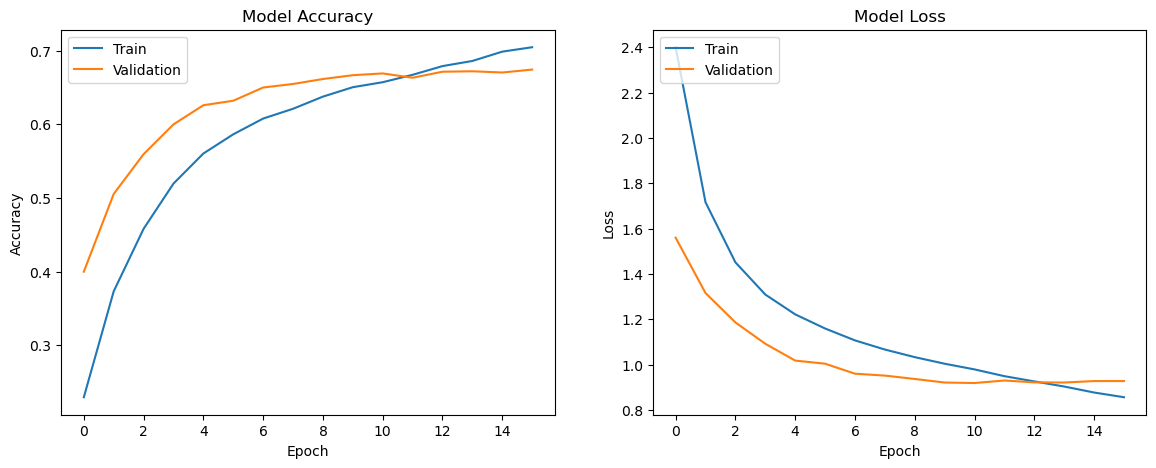

In [36]:
# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history_pretrained_resnet50.history['accuracy'])
plt.plot(history_pretrained_resnet50.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_pretrained_resnet50.history['loss'])
plt.plot(history_pretrained_resnet50.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


## Evaluate the Model on the Test Set

In [37]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 13380 images belonging to 7 classes.


In [38]:
# Evaluate the model on the test set
test_steps = test_generator.samples // test_generator.batch_size
test_loss, test_accuracy = pretrained_efficientnet.evaluate(test_generator, steps=test_steps, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

/Users/shwetakakade/miniconda3/envs/dissertation/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


418/418 ━━━━━━━━━━━━━━━━━━━━ 164s 391ms/step - accuracy: 0.6249 - loss: 1.0304
Test Loss: 0.9181
Test Accuracy: 0.6711


## Predict on the Test Set and Calculate Metrics

In [41]:
# Collect predictions manually to avoid the mismatch error
test_generator.reset()  # Ensure generator is at the start
predictions = pretrained_efficientnet.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1, verbose=1)

# Get the true and predicted labels
y_true = test_generator.classes  # Ground truth labels
y_pred = np.argmax(predictions, axis=1)[:len(y_true)]  # Predictions, ensure length matches y_true

# Calculate precision, recall, and F1 score
report = classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys())
print(report)

419/419 ━━━━━━━━━━━━━━━━━━━━ 172s 409ms/step
              precision    recall  f1-score   support

       angry       0.59      0.62      0.61      1716
     disgust       0.62      0.54      0.58       890
        fear       0.66      0.40      0.50      1661
       happy       0.83      0.89      0.86      3070
     neutral       0.60      0.63      0.62      2222
         sad       0.59      0.67      0.63      2115
    surprise       0.69      0.70      0.70      1706

    accuracy                           0.67     13380
   macro avg       0.65      0.64      0.64     13380
weighted avg       0.67      0.67      0.67     13380



## Plot the Confusion Matrix

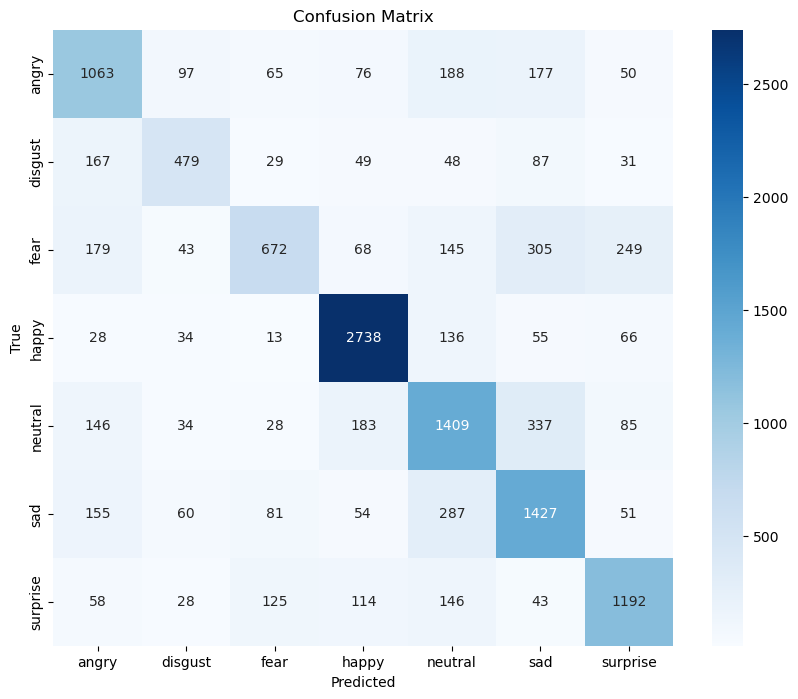

In [42]:
# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()